In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import git
import sys
import os
import time
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.visualization.visualize_sequences import viz_sequence
from argoverse.map_representation.map_api import ArgoverseMap

repo = git.Repo('.', search_parent_directories=True)
BASE_DIR = repo.working_tree_dir
sys.path.append(BASE_DIR)

import model.datasets.argoverse.dataset as dataset
import model.datasets.argoverse.dataset_utils as dataset_utils 
import model.datasets.argoverse.map_functions as map_functions

# Set root_dir to the correct path to your dataset folder

split_name = "train"
root_dir = os.path.join(BASE_DIR,f'data/datasets/argoverse/motion-forecasting/{split_name}/data/')

avm = ArgoverseMap()
afl = ArgoverseForecastingLoader(root_dir)

print('Total number of sequences:',len(afl))

Total number of sequences: 205942


In [3]:
files, num_files = dataset_utils.load_list_from_folder(root_dir)

file_id_list = []
root_file_name = None
for file_name in files:
    if not root_file_name:
        root_file_name = os.path.dirname(os.path.abspath(file_name))
    file_id = int(os.path.normpath(file_name).split('/')[-1].split('.')[0])
    file_id_list.append(file_id)
file_id_list.sort()
print("Num files: ", num_files)

Num files:  205942


dfs_threshold_front, dfs_threshold_back:  139.5 84.0
Time consumed:  0.31757116317749023


/home/denso/anaconda3/envs/carlos_vsr_mapfe4mp/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +


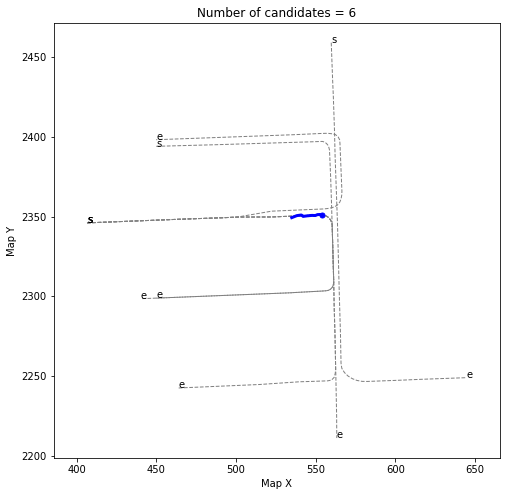

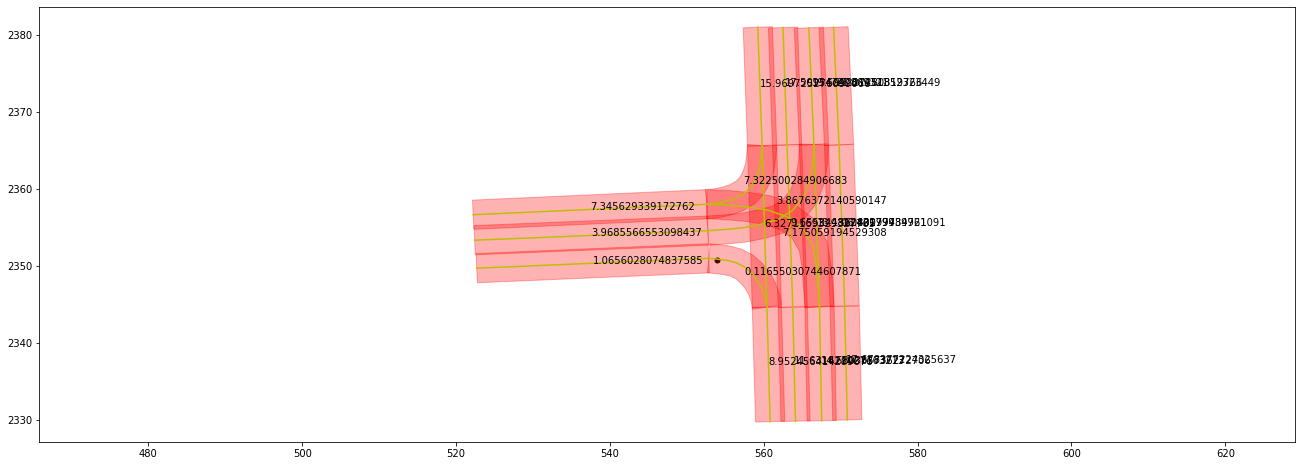

(<argoverse.map_representation.lane_segment.LaneSegment at 0x7f88c1629ee0>,
 0.9766899385107842,
 array([[ 552.84644569, 2350.99759536],
        [ 553.06960494, 2350.97532451],
        [ 553.29276418, 2350.95305366],
        [ 553.51592343, 2350.93078281],
        [ 553.73908267, 2350.90851196],
        [ 553.96224192, 2350.88624111],
        [ 554.18505091, 2350.86087659],
        [ 554.40754071, 2350.83269279],
        [ 554.63003051, 2350.80450898],
        [ 554.85252032, 2350.77632518],
        [ 555.07501012, 2350.74814137],
        [ 555.29712174, 2350.71804415],
        [ 555.51360405, 2350.65946557],
        [ 555.73008636, 2350.600887  ],
        [ 555.94656867, 2350.54230843],
        [ 556.16305098, 2350.48372986],
        [ 556.37953329, 2350.42515128],
        [ 556.5848957 , 2350.33826244],
        [ 556.78337497, 2350.23384969],
        [ 556.98185423, 2350.12943695],
        [ 557.18033349, 2350.0250242 ],
        [ 557.37881275, 2349.92061145],
        [ 557.57166   ,

In [9]:
split_name = "train"
seq_id = 4567
seq_path = f"{BASE_DIR}/data/datasets/argoverse/motion-forecasting/{split_name}/data/{seq_id}.csv"
df = pd.read_csv(seq_path, dtype={"TIMESTAMP": str})

obs_len = 20
pred_len = 30

RAW_DATA_FORMAT = {
    "TIMESTAMP": 0,
    "TRACK_ID": 1,
    "OBJECT_TYPE": 2,
    "X": 3,
    "Y": 4,
    "CITY_NAME": 5,
}

# Get social and map features for the agent

agent_track = df[df["OBJECT_TYPE"] == "AGENT"].values

# Map features extraction

start = time.time()

map_features_utils_instance = map_functions.MapFeaturesUtils()
map_features, map_feature_helpers = map_features_utils_instance.compute_map_features(
        agent_track,
        seq_id,
        split_name,
        obs_len,
        obs_len + pred_len,
        RAW_DATA_FORMAT,
        "test", # mode (if test, return K plausible candidates. Otherwise, return best possible candidate)
        avm    
    )

end = time.time()
print("Time consumed: ", end-start)

agent_xy = agent_track[:,[RAW_DATA_FORMAT["X"],RAW_DATA_FORMAT["Y"]]].astype("float")
city_name = agent_track[0, RAW_DATA_FORMAT["CITY_NAME"]]
avm.get_nearest_centerline(agent_xy[obs_len-1,:], city_name, visualize=True)

Filter:  None
Vel:  [ 0.          0.         33.80469736  0.         28.61970051  4.70304031
  9.84011396 30.30187361  3.19148913  7.38757535  6.63116251  6.235707
  7.14046658  5.62111413  3.87888193  6.8364896  14.45046352 16.34712993
 11.55558498]
Acc:  [   0.          338.04697361 -338.04697361  286.19700513 -239.16660199
   51.37073645  204.61759649 -271.10384482   41.96086223   -7.56412839
   -3.95455506    9.04759578  -15.19352452  -17.42232199   29.57607668
   76.13973925   18.96666409  -47.91544948]
Estimated horizon without acceleration:  30.843400272697288
Estimated horizon with acceleration:  51.225751646779194


(10.28113342423243, 4.529411416462646)

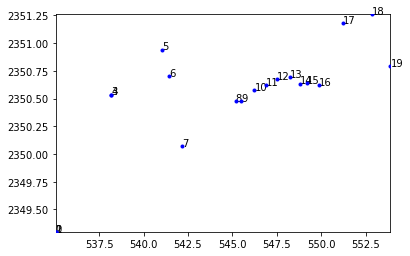

In [4]:
split_name = "train"
seq_id = 4567
seq_path = f"{BASE_DIR}/data/datasets/argoverse/motion-forecasting/{split_name}/data/{seq_id}.csv"
df = pd.read_csv(seq_path, dtype={"TIMESTAMP": str})

obs_len = 20
pred_len = 30

RAW_DATA_FORMAT = {
    "TIMESTAMP": 0,
    "TRACK_ID": 1,
    "OBJECT_TYPE": 2,
    "X": 3,
    "Y": 4,
    "CITY_NAME": 5,
}

# Get social and map features for the agent

agent_track = df[df["OBJECT_TYPE"] == "AGENT"].values

agent_xy = agent_track[:,[RAW_DATA_FORMAT["X"],RAW_DATA_FORMAT["Y"]]].astype("float")

map_features_utils_instance = map_functions.MapFeaturesUtils()
map_features_utils_instance.get_agent_velocity_and_acceleration(agent_xy,debug=True)
# map_features_utils_instance.get_agent_velocity_and_acceleration(agent_xy,filter="savgol",debug=True)
# map_features_utils_instance.get_agent_velocity_and_acceleration(agent_xy,filter="cubic_spline",debug=True)
# map_features_utils_instance.get_agent_velocity_and_acceleration(agent_xy,filter="savgol+cubic_spline",debug=True)
# map_features_utils_instance.get_agent_velocity_and_acceleration(agent_xy,filter="least_squares",debug=True)

Filter:  savgol
Vel:  [ 7.24386372 14.48772744 14.0435408  20.98302421 11.81380639 11.91710244
 12.96865481 17.30314233 13.32676164  3.81961236  7.00576166  6.64045685
  6.61449517  5.38052968  4.44895051  7.56493046 13.58517001 15.72842065
 12.19952397]
Acc:  [ 72.4386372   -4.44186645  69.39483411 -91.6921782    1.03296053
  10.51552372  43.34487522 -39.7638069  -95.07149287  31.86149304
  -3.65304806  -0.25961682 -12.33965492  -9.31579175  31.15979959
  60.20239543  21.43250645 -35.28896686]
Estimated horizon without acceleration:  31.884021854316707
Estimated horizon with acceleration:  42.08069285197018


(10.628007284772236, 2.265926888367438)

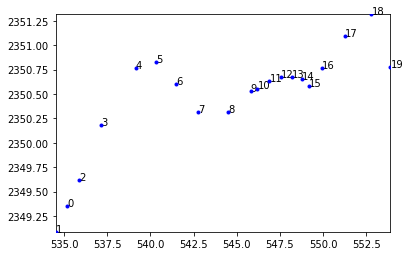

In [5]:
map_features_utils_instance.get_agent_velocity_and_acceleration(agent_xy,filter="savgol",debug=True)

Filter:  cubic_spline
Vel:  [ 9.17769923  8.55548234  9.44214142  6.517722   32.85648625 34.02961898
  5.58282362  4.01945314 20.03563771 32.33873715 15.89279705  3.4535598
  7.37192677 10.5584328  25.58775917 32.44850185 16.49789064  0.69123522
  1.48268549  8.11968441  8.5570863   6.30583633  5.60137415  5.98666054
  6.64039007  7.0780561   6.71218669  5.75567569  4.51180803  3.63404446
  4.04417064  5.83179899  8.70075606 13.20402986 15.73187741 16.33187515
 15.63355533 13.27098894  9.39483544]
Acc:  [ -12.44433794   17.73318157  -58.48838834  526.77528508   23.46265449
 -568.93590706  -31.26740961  320.32369142  246.06198878 -328.91880198
 -248.7847451    78.36733939   63.73012064  300.58652732  137.2148536
 -319.01222411 -316.13310848   15.82900548  132.73997842    8.74803778
  -45.02499951  -14.08924357    7.7057278    13.07459068    8.75332056
   -7.31738829  -19.13021989  -24.87735317  -17.5552715     8.20252365
   35.75256708   57.37914123   90.06547611   50.55695093   11.9999

(11.06170871717418, -0.6957970210324383)

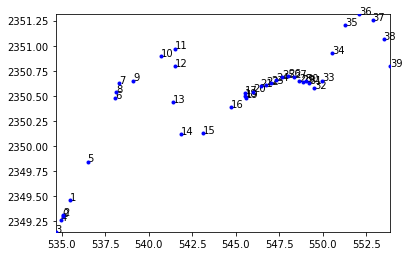

In [6]:
map_features_utils_instance.get_agent_velocity_and_acceleration(agent_xy,filter="cubic_spline",debug=True)

Filter:  savgol+cubic_spline
Vel:  [13.83734379  2.0362355   7.06492931 13.46603302 20.75037275 18.11671339
 20.96548729 18.23161862 12.3918344   9.45417652 10.95467578 12.91814685
 13.04988442 13.51516485 15.55040743 16.70347778 14.96485883 10.56262314
  5.50033545  3.43837849  5.16991096  7.15214165  7.09995706  6.43333418
  6.36343126  6.30529677  5.76488057  4.96671007  4.38817336  4.40265033
  5.5340535   7.92152834 10.87359545 13.62943648  7.63603304 15.30164945
 14.46356059 13.07895517 12.4186019 ]
Acc:  [-236.02216589  100.57387617  128.02207435  145.68679458  -52.67318731
   56.97547801  -54.67737329 -116.79568451  -58.75315764   30.00998529
   39.26942134    2.63475152    9.30560847   40.70485159   23.06140702
  -34.772379    -88.04471384 -101.24575372  -41.23913916   34.63064936
   39.64461385   -1.04369176  -13.33245776   -1.39805832   -1.1626899
  -10.80832387  -15.96341     -11.57073418    0.28953927   22.62806356
   47.74949671   59.04134214   55.11682056 -119.8680688   

(10.282184535613244, 0.1979532344856949)

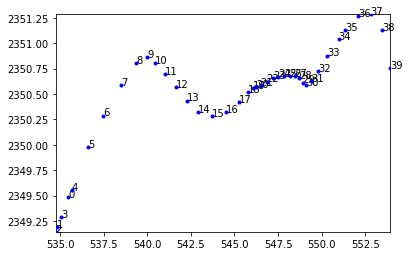

In [7]:
map_features_utils_instance.get_agent_velocity_and_acceleration(agent_xy,filter="savgol+cubic_spline",debug=True)

Filter:  least_squares
Vel:  [15.98758627 14.89743189 13.90179968 12.99820282 12.18363605 11.45460807
 10.80723951 10.23744083  9.74117629  9.31480788  8.9554976   8.66163016
  8.4332014   8.27210494  8.18224116  8.16937952  8.24073505  8.40428118
  8.66790373]
Acc:  [-10.90154377  -9.9563221   -9.03596864  -8.14566766  -7.29027982
  -6.47368564  -5.6979868   -4.96264535  -4.26368416  -3.59310271
  -2.93867448  -2.28428751  -1.6109646   -0.89863783  -0.12861638
   0.7135553    1.63546131   2.63622541]
Estimated horizon without acceleration:  29.839621445291975
Estimated horizon with acceleration:  15.140047526652886


(9.946540481763991, -3.266571981919798)

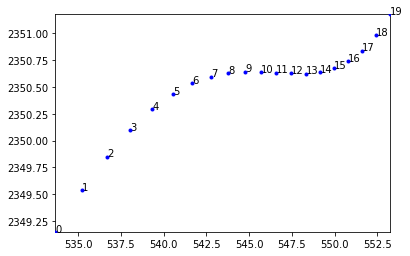

In [8]:
map_features_utils_instance.get_agent_velocity_and_acceleration(agent_xy,filter="least_squares",debug=True)

In [8]:
seq_path = f"{root_dir}/13606.csv"
viz = True

# Visualize sequence

start = time.time()
viz_sequence(afl.get(seq_path).seq_df, show=viz)
end = time.time()
print("Viz seq: ", end-start)

obs_len = 20
obs_origin = 20

data = dataset_utils.read_file(seq_path) 
origin_pos, city_name = dataset_utils.get_origin_and_city(data,obs_origin)

# Visualize candidate centerlines

agent_obs_traj = afl.get(seq_path).agent_traj[:obs_len]

start = time.time()
candidate_centerlines = avm.get_candidate_centerlines_for_traj(agent_obs_traj, city_name, viz=viz)
end = time.time()
print("Candidate centerlines: ", end-start)

start = time.time()
candidate_centerlines = avm.get_candidate_centerlines_for_traj_custom(agent_obs_traj, city_name, viz=viz)
end = time.time()
print("Candidate centerlines custom: ", end-start)

# Visualize nearest centerline

start = time.time()
nearest_centerline = avm.get_nearest_centerline(np.array(origin_pos), city_name, visualize=viz)
end = time.time()
print("Nearest centerline: ", end-start)

# Visualize lane direction in the last observation frame

agent_traj = afl.get(seq_path).agent_traj
start = time.time()
lane_direction = avm.get_lane_direction(agent_traj[0], city_name, visualize=viz)
end = time.time()
print("Get lane direction: ", end-start)

13606

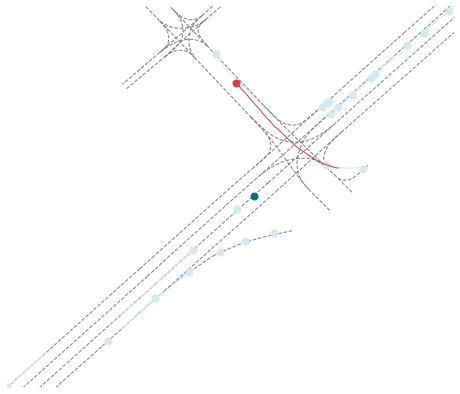

Viz seq:  7.508663892745972


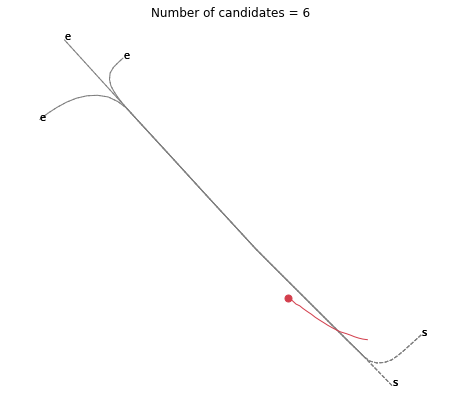

Candidate centerlines:  0.06867408752441406


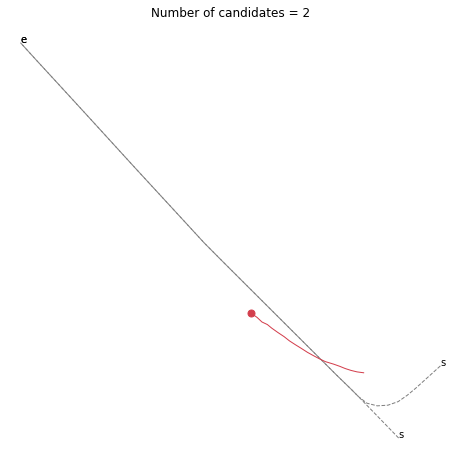

Candidate centerlines custom:  0.0564885139465332


/home/denso/anaconda3/envs/carlos_vsr_mapfe4mp/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +


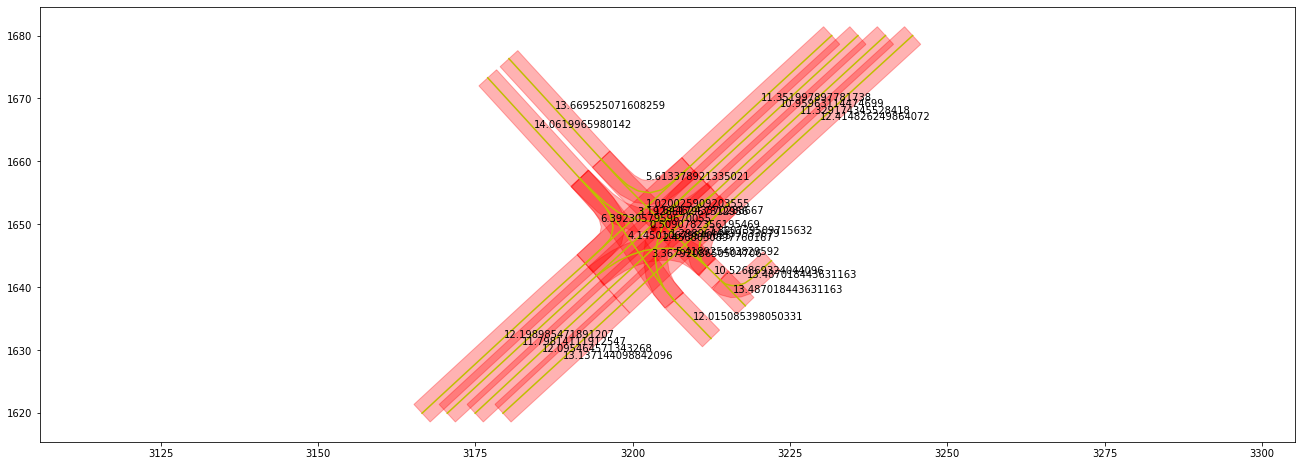

Nearest centerline:  0.22411537170410156


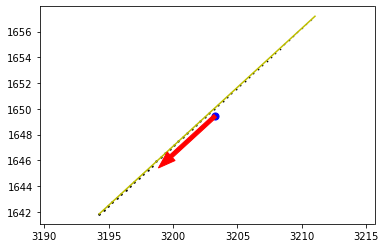

yaw:  -2.3999570973543616
Yaw:  -137.50741269087254
Get lane direction:  0.4046773910522461


In [17]:
seq_path = f"{root_dir}/2.csv"
viz = True

# Visualize sequence

start = time.time()
viz_sequence(afl.get(seq_path).seq_df, show=viz)
end = time.time()
print("Viz seq: ", end-start)

obs_len = 20
obs_origin = 20

data = dataset_utils.read_file(seq_path) 
origin_pos, city_name = dataset_utils.get_origin_and_city(data,obs_origin)

# Visualize candidate centerlines

agent_obs_traj = afl.get(seq_path).agent_traj[:obs_len]

start = time.time()
candidate_centerlines = avm.get_candidate_centerlines_for_traj(agent_obs_traj, city_name, viz=viz)
end = time.time()
print("Candidate centerlines: ", end-start)

start = time.time()
candidate_centerlines = avm.get_candidate_centerlines_for_traj_custom(agent_obs_traj, city_name, viz=viz)
end = time.time()
print("Candidate centerlines custom: ", end-start)

# Visualize nearest centerline

start = time.time()
nearest_centerline = avm.get_nearest_centerline(np.array(origin_pos), city_name, visualize=viz)
end = time.time()
print("Nearest centerline: ", end-start)

# Visualize lane direction in the last observation frame

agent_traj = afl.get(seq_path).agent_traj
start = time.time()
lane_direction, confidence = avm.get_lane_direction(agent_traj[obs_len-1], city_name, visualize=viz)
yaw = math.atan2(lane_direction[1],lane_direction[0])
print("yaw: ", yaw)
print("Yaw: ", math.degrees(yaw))

end = time.time()
print("Get lane direction: ", end-start)

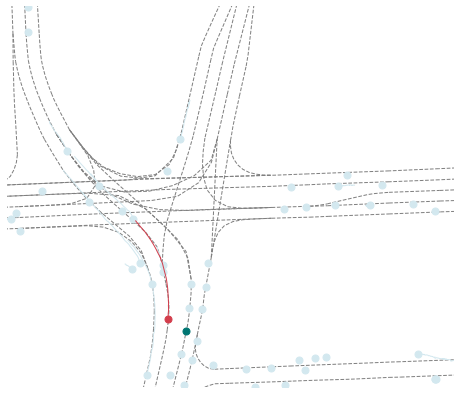

Viz seq:  7.358400821685791


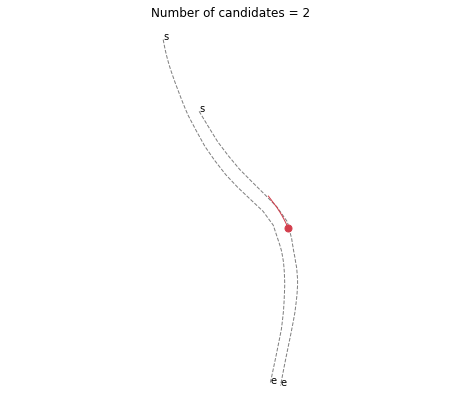

Candidate centerlines:  0.05509161949157715


/home/denso/anaconda3/envs/carlos_vsr_mapfe4mp/lib/python3.8/site-packages/descartes/patch.py:63: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  concatenate([asarray(t.exterior)[:, :2]] +


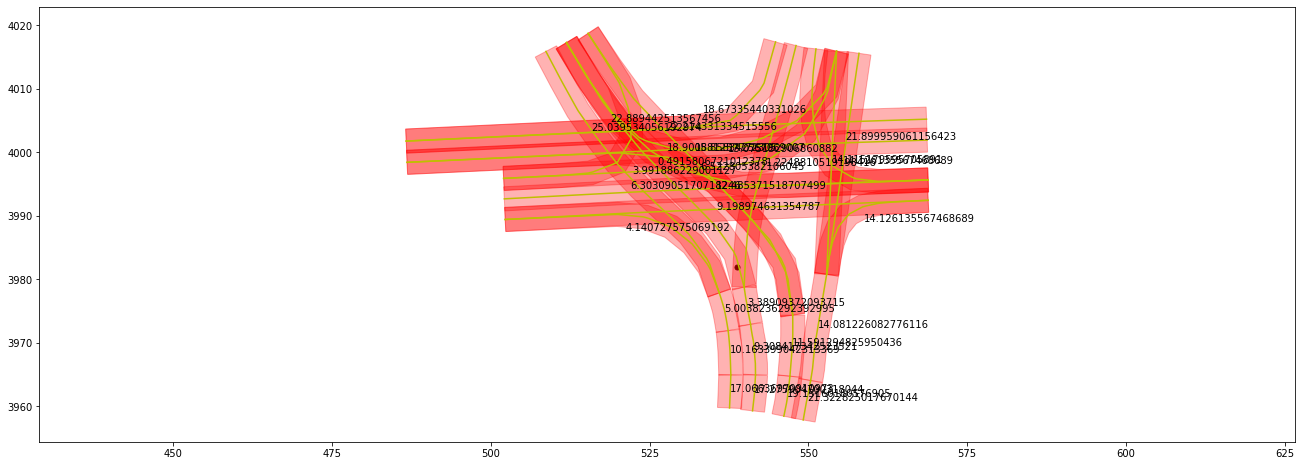

Nearest centerline:  0.23919367790222168


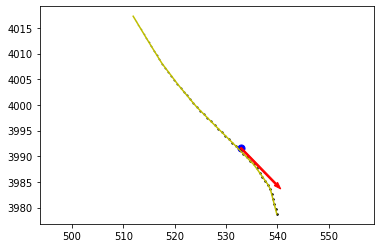

Get lane direction:  0.4093010425567627


In [6]:
seq_path = f"{root_dir}/4.csv"
viz = True

# Visualize sequence

start = time.time()
viz_sequence(afl.get(seq_path).seq_df, show=viz)
end = time.time()
print("Viz seq: ", end-start)

obs_len = 20
obs_origin = 20

data = dataset_utils.read_file(seq_path) 
origin_pos, city_name = dataset_utils.get_origin_and_city(data,obs_origin)

# Visualize candidate centerlines

agent_obs_traj = afl.get(seq_path).agent_traj[:obs_len]
start = time.time()
candidate_centerlines = avm.get_candidate_centerlines_for_traj(agent_obs_traj, city_name, viz=viz)
end = time.time()
print("Candidate centerlines: ", end-start)

# Visualize nearest centerline

start = time.time()
nearest_centerline = avm.get_nearest_centerline(np.array(origin_pos), city_name, visualize=viz)
end = time.time()
print("Nearest centerline: ", end-start)

# Visualize lane direction in the last observation frame

agent_traj = afl.get(seq_path).agent_traj
start = time.time()
lane_direction = avm.get_lane_direction(agent_traj[0], city_name, visualize=viz)
end = time.time()
print("Get lane direction: ", end-start)

In [9]:
# candidate_centerlines[0].shape
len(candidate_centerlines)

# agent_obs_traj
np.array(origin_pos)

array([ 205.83381422, 1532.52969298])

In [5]:
city_name

'PIT'

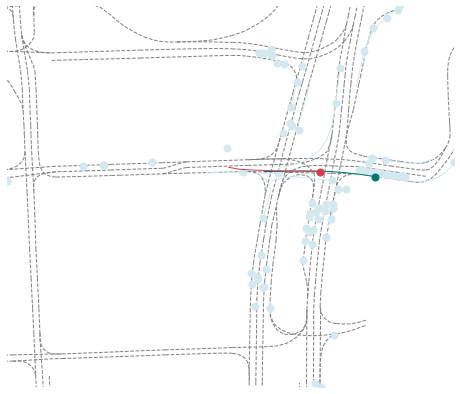

Viz seq:  7.969861745834351


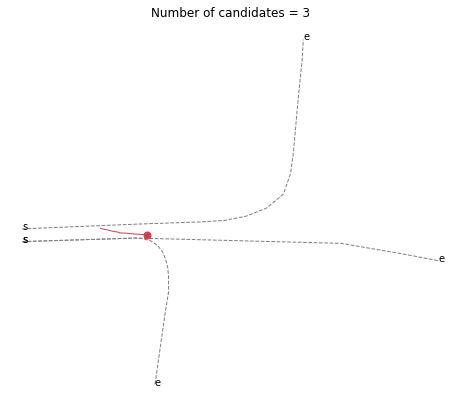

Candidate centerlines:  0.054201602935791016


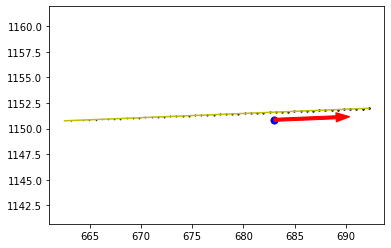

Get lane direction:  0.42394495010375977


In [5]:
seq_path = f"{root_dir}/18359.csv"
viz = True

# Visualize sequence

start = time.time()
viz_sequence(afl.get(seq_path).seq_df, show=viz)
end = time.time()
print("Viz seq: ", end-start)

obs_len = 20
obs_origin = 20

data = dataset_utils.read_file(seq_path) 
origin_pos, city_name = dataset_utils.get_origin_and_city(data,obs_origin)

# Visualize candidate centerlines

agent_obs_traj = afl.get(seq_path).agent_traj[:obs_len]
start = time.time()
# candidate_centerlines = avm.get_candidate_centerlines_for_traj(agent_obs_traj, city_name, viz=viz)
end = time.time()
print("Candidate centerlines: ", end-start)

# Visualize lane direction in the last observation frame

agent_traj = afl.get(seq_path).agent_traj
start = time.time()
lane_direction = avm.get_lane_direction(agent_traj[0], city_name, visualize=viz)
end = time.time()
print("Get lane direction: ", end-start)

In [7]:
candidate_centerlines[0].shape

(50, 2)

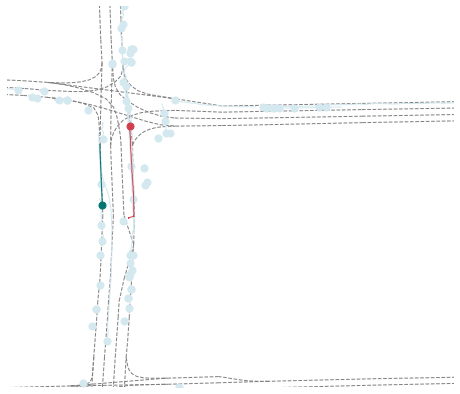

Viz seq:  8.7499361038208


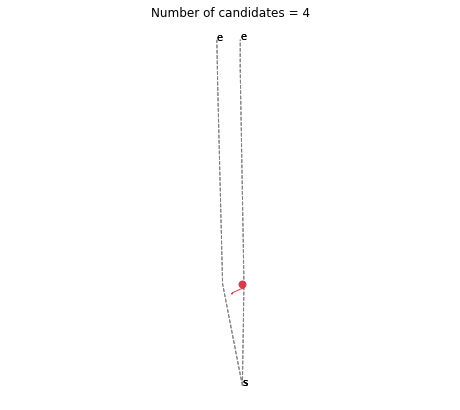

Candidate centerlines:  0.061635494232177734


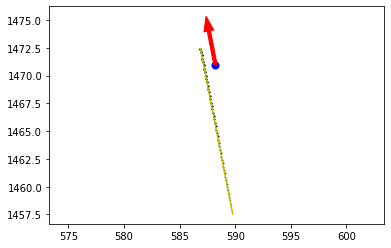

Get lane direction:  0.4422447681427002


In [3]:
seq_path = f"{root_dir}/422.csv"
viz = True

# Visualize sequence

start = time.time()
viz_sequence(afl.get(seq_path).seq_df, show=viz)
end = time.time()
print("Viz seq: ", end-start)

obs_len = 20
obs_origin = 20

data = dataset_utils.read_file(seq_path) 
origin_pos, city_name = dataset_utils.get_origin_and_city(data,obs_origin)

# Visualize candidate centerlines

agent_obs_traj = afl.get(seq_path).agent_traj[:obs_len]
start = time.time()
candidate_centerlines = avm.get_candidate_centerlines_for_traj(agent_obs_traj, city_name, viz=viz)
end = time.time()
print("Candidate centerlines: ", end-start)

# Visualize lane direction in the last observation frame

agent_traj = afl.get(seq_path).agent_traj
start = time.time()
lane_direction = avm.get_lane_direction(agent_traj[0], city_name, visualize=viz)
end = time.time()
print("Get lane direction: ", end-start)

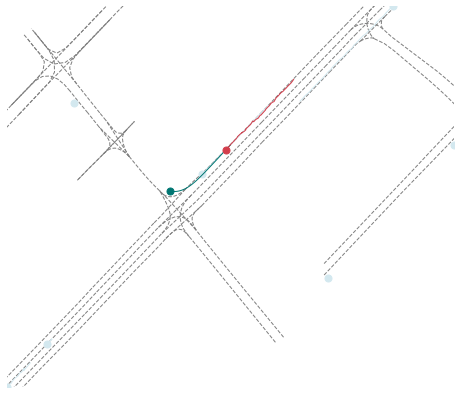

Viz seq:  7.000475883483887


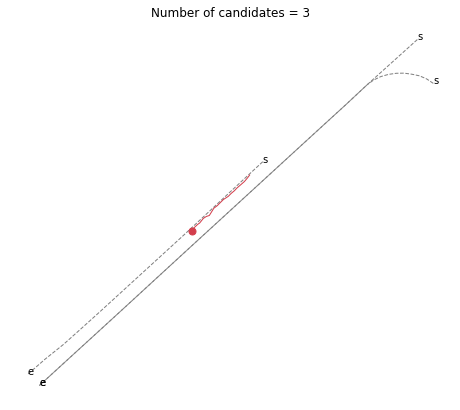

Candidate centerlines:  0.05938148498535156


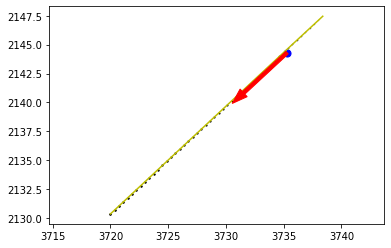

Get lane direction:  0.41574573516845703


In [56]:

seq_path = f"{root_dir}/7016.csv"
viz = True

# Visualize sequence

start = time.time()
viz_sequence(afl.get(seq_path).seq_df, show=viz)
end = time.time()
print("Viz seq: ", end-start)

obs_len = 20
obs_origin = 20

data = dataset_utils.read_file(seq_path) 
origin_pos, city_name = dataset_utils.get_origin_and_city(data,obs_origin)

# Visualize candidate centerlines

agent_obs_traj = afl.get(seq_path).agent_traj[:obs_len]
start = time.time()
candidate_centerlines = avm.get_candidate_centerlines_for_traj(agent_obs_traj, city_name, viz=viz)
end = time.time()
print("Candidate centerlines: ", end-start)

# Visualize lane direction in the last observation frame

agent_traj = afl.get(seq_path).agent_traj
start = time.time()
lane_direction = avm.get_lane_direction(agent_traj[0], city_name, visualize=viz)
end = time.time()
print("Get lane direction: ", end-start)

In [57]:
len(candidate_centerlines)

3

In [60]:
candidate_centerlines[2].shape

(20, 2)